# Clasificación de Orquídeas Iris con Lógica Difusa

**Objetivo:**
El objetivo de este notebook es construir y evaluar un sistema de control de lógica difusa para clasificar especies de orquídeas del dataset Iris. Se definirán variables lingüísticas y funciones de pertenencia para las características de las flores (longitud y ancho de sépalos y pétalos) y para la especie de salida. Se establecerán reglas difusas para realizar la clasificación y se evaluará la precisión del sistema.

## 1. Carga de Librerías

Se importarán las bibliotecas necesarias:
* **`numpy`**: Para operaciones numéricas, especialmente la creación de arrays para los universos de las variables difusas.
* **`pandas`**: Para la manipulación de datos, específicamente para cargar y manejar el dataset Iris en un DataFrame.
* **`matplotlib.pyplot`**: Para la creación de gráficos y visualizaciones.
* **`seaborn`**: Para mejorar el estilo visual de los gráficos.
* **`skfuzzy` y `skfuzzy.control`**: Para todas las funcionalidades de lógica difusa, incluyendo la definición de antecedentes, consecuentes, funciones de pertenencia y sistemas de control.
* **`sklearn.datasets`**: Para cargar el dataset Iris.
* **`sklearn.model_selection`**: Para dividir el dataset en conjuntos de entrenamiento y prueba.

In [30]:
# Celda para instalar las bibliotecas si es necesario (ej. en Google Colab)
!pip install scikit-fuzzy

In [31]:
# Estas líneas sirven para que el código se actualice automáticamente (opcional).
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Asegura que los gráficos se muestren inline en Jupyter
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Establece el estilo de los gráficos en "whitegrid".
sns.set(style="whitegrid")

## 2. Funciones Personalizadas

Esta sección define funciones auxiliares para cargar, visualizar y evaluar los datos y el sistema difuso.

### Descripción de la Función: `cargar_datos`

**Objetivo Principal:**
Cargar el dataset Iris, convertirlo a un DataFrame de pandas, añadir nombres de especies y mostrar información básica del dataset.

**Características:**
* **Procesamiento:**
    1. Carga el dataset "Iris" de `sklearn.datasets`.
    2. Convierte los datos a un DataFrame de pandas.
    3. Añade una columna con los nombres de las especies correspondientes a las clases numéricas.
    4. Imprime las dimensiones, las primeras filas y estadísticas descriptivas del dataset.
* **Valor de Retorno:**
    * `df`: DataFrame con los datos.
    * `feature_names`: Lista con los nombres de las características.
    * `target_names`: Lista con los nombres de las especies objetivo.

In [33]:
def cargar_datos():
    """
    Carga el dataset de Iris y lo prepara para su uso.
    Devuelve el DataFrame, los nombres de las características y los nombres de las especies.
    """
    print("Cargando el dataset de las orquídeas (Iris)...")
    iris = load_iris()
    df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

    # Agrega una columna 'target' al DataFrame y luego 'species' con los nombres.
    df['target'] = iris.target
    df['species'] = df['target'].map({
        0: 'Iris-setosa',
        1: 'Iris-versicolor',
        2: 'Iris-virginica'
    })

    print("Dimensiones del dataset:", df.shape)
    print("\nPrimeras filas del dataset:")
    print(df.head())
    print("\nEstadísticas descriptivas:")
    print(df.describe())

    return df, iris.feature_names, iris.target_names

### Descripción de la Función: `visualizar_datos`

**Objetivo Principal:**
Crear histogramas para cada una de las cuatro características de las flores, mostrando la distribución de valores para cada especie de Iris.

**Características:**
* **Entrada:**
    * `df`: DataFrame de pandas con los datos de las flores.
* **Procesamiento:**
    * Genera 4 subplots, uno para cada característica.
    * Utiliza `seaborn.histplot` para mostrar la distribución de cada característica, diferenciando por especie mediante colores.
* **Salida:**
    * Muestra los gráficos generados.

In [34]:
def visualizar_datos(df):
    """
    Visualiza la distribución de las características de las orquídeas.

    Args:
        df (pd.DataFrame): DataFrame con los datos de las flores.
    """
    print("\nVisualizando la distribución de las características...")
    plt.figure(figsize=(15, 10))

    # Histogramas de cada característica por especie
    for i, feature in enumerate(df.columns[:4]): # Asumiendo que las primeras 4 columnas son las características
        plt.subplot(2, 2, i + 1)
        sns.histplot(data=df, x=feature, hue='species', multiple='stack', palette='viridis', bins=10)
        plt.title(f'Distribución de {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

### Descripción de la Función: `crear_sistema_fuzzy`

**Objetivo Principal:**
Construir el clasificador de lógica difusa.

**Características:**
* **Entrada:**
    * `feature_names`: Lista de nombres de las características (no se usa directamente en esta versión, pero es buena práctica pasarla si fuera necesario).
* **Procesamiento:**
    1. Define variables de entrada (antecedentes) para las cuatro medidas de las flores.
    2. Define la variable de salida (consecuente) para la especie de la flor.
    3. Crea funciones de pertenencia triangulares ("corto", "medio", "largo" o similar) para cada variable.
    4. Grafica estas funciones de pertenencia.
    5. Establece reglas difusas (combinaciones de AND, OR) para conectar las entradas con la salida.
    6. Crea un `ControlSystem` y un `ControlSystemSimulation` a partir de las reglas.
* **Valor de Retorno:**
    * `simulator`: Simulador del sistema fuzzy listo para usarse.

In [35]:
def crear_sistema_fuzzy(feature_names):
    """
    Crea un sistema de lógica difusa para clasificar orquídeas.

    Args:
        feature_names (list): Lista de nombres de las características.

    Returns:
        ctrl.ControlSystemSimulation: Simulador del sistema fuzzy.
    """
    print("\nCreando el sistema fuzzy...")

    # Crear las variables de entrada (antecedentes)
    # Los rangos se ajustan según los valores típicos del dataset Iris.
    sepal_length = ctrl.Antecedent(np.arange(4, 8.1, 0.1), 'sepal_length') # Largo del sépalo
    sepal_width = ctrl.Antecedent(np.arange(2, 4.5, 0.1), 'sepal_width')   # Ancho del sépalo
    petal_length = ctrl.Antecedent(np.arange(1, 7.1, 0.1), 'petal_length') # Largo del pétalo
    petal_width = ctrl.Antecedent(np.arange(0, 2.6, 0.1), 'petal_width')  # Ancho del pétalo

    # Crear la variable de salida (consecuente)
    # Representa las clases: 0 (setosa), 1 (versicolor), 2 (virginica)
    species = ctrl.Consequent(np.arange(0, 2.1, 0.1), 'species')

    # Definir las funciones de pertenencia para cada variable de entrada
    # Longitud del sépalo
    sepal_length['corto'] = fuzz.trimf(sepal_length.universe, [4, 4, 5.8])
    sepal_length['medio'] = fuzz.trimf(sepal_length.universe, [5.0, 6.0, 7.0])
    sepal_length['largo'] = fuzz.trimf(sepal_length.universe, [6.0, 8, 8])

    # Ancho del sépalo
    sepal_width['estrecho'] = fuzz.trimf(sepal_width.universe, [2, 2, 3.0])
    sepal_width['medio'] = fuzz.trimf(sepal_width.universe, [2.8, 3.3, 3.8])
    sepal_width['ancho'] = fuzz.trimf(sepal_width.universe, [3.5, 4.5, 4.5])

    # Longitud del pétalo
    petal_length['corto'] = fuzz.trimf(petal_length.universe, [1, 1, 2.5])
    petal_length['medio'] = fuzz.trimf(petal_length.universe, [2, 4, 5.5]) # Ajustado para versicolor/virginica
    petal_length['largo'] = fuzz.trimf(petal_length.universe, [4.5, 7, 7])

    # Ancho del pétalo
    petal_width['estrecho'] = fuzz.trimf(petal_width.universe, [0, 0, 0.8])
    petal_width['medio'] = fuzz.trimf(petal_width.universe, [0.6, 1.3, 2.0]) # Ajustado
    petal_width['ancho'] = fuzz.trimf(petal_width.universe, [1.5, 2.5, 2.5])

    # Definir las funciones de pertenencia para la variable de salida
    # Se usan valores más separados para facilitar la desfusificación a clases discretas
    species['setosa'] = fuzz.trimf(species.universe, [0, 0, 0.5])       # Clase 0
    species['versicolor'] = fuzz.trimf(species.universe, [0.5, 1, 1.5]) # Clase 1
    species['virginica'] = fuzz.trimf(species.universe, [1.5, 2, 2])    # Clase 2


    print("\nVisualizando Funciones de Pertenencia:")
    sepal_length.view()
    plt.title("Funciones de Pertenencia para Longitud del Sépalo")
    plt.show()
    sepal_width.view()
    plt.title("Funciones de Pertenencia para Ancho del Sépalo")
    plt.show()
    petal_length.view()
    plt.title("Funciones de Pertenencia para Longitud del Pétalo")
    plt.show()
    petal_width.view()
    plt.title("Funciones de Pertenencia para Ancho del Pétalo")
    plt.show()
    species.view()
    plt.title("Funciones de Pertenencia para Especie")
    plt.show()

    # Definir las reglas fuzzy
    print("\nDefiniendo las reglas fuzzy...")
    # Reglas ajustadas basadas en características conocidas de las especies Iris
    # Iris Setosa: pétalos cortos y estrechos
    rule1 = ctrl.Rule(
        (petal_length['corto'] & petal_width['estrecho']),
        species['setosa']
    )
    # Iris Versicolor: pétalos y anchos de pétalos medios, longitud de sépalo media
    rule2 = ctrl.Rule(
        (petal_length['medio'] & petal_width['medio']) &
        (sepal_length['medio'] | sepal_length['corto']) & # Puede tener sépalos cortos o medios
        (sepal_width['estrecho'] | sepal_width['medio']),
        species['versicolor']
    )
    # Iris Virginica: pétalos y anchos de pétalos largos, longitud de sépalo larga
    rule3 = ctrl.Rule(
        (petal_length['largo'] & petal_width['ancho']),
        species['virginica']
    )
    # Reglas adicionales para mejorar la clasificación y cubrir más casos
    # Si el pétalo es corto pero el ancho del sépalo es ancho, podría ser setosa
    rule4 = ctrl.Rule(
        petal_length['corto'] & sepal_width['ancho'],
        species['setosa']
    )
    # Si la longitud del pétalo es media y el ancho del pétalo es ancho, tiende a virginica
    rule5 = ctrl.Rule(
        petal_length['medio'] & petal_width['ancho'],
        species['virginica']
    )
    # Si la longitud del pétalo es larga y el ancho del pétalo es medio, también tiende a virginica
    rule6 = ctrl.Rule(
        petal_length['largo'] & petal_width['medio'],
        species['virginica']
    )


    print("\nReglas definidas!")

    # Crear el sistema de control: ASEGÚRATE DE INCLUIR TODAS LAS REGLAS DEFINIDAS
    # El error original podría estar en no incluir todas las reglas aquí
    system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
    simulator = ctrl.ControlSystemSimulation(system)

    return simulator

### Descripción de la Función: `evaluar_sistema_fuzzy`

**Objetivo Principal:**
Evaluar el rendimiento del sistema difuso en un conjunto de prueba.

**Características:**
* **Entrada:**
    * `simulator`: Simulador del sistema fuzzy.
    * `df`: DataFrame con los datos completos.
    * `feature_names`: Lista de nombres de las características.
* **Procesamiento:**
    1. Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%).
    2. Para cada muestra en el conjunto de prueba:
        a. Asigna los valores de las características de la muestra a las entradas del simulador.
        b. Ejecuta `simulator.compute()`.
        c. Obtiene el valor de salida difuso para 'species'.
        d. Convierte el valor de salida a una clase discreta (0, 1, o 2) basándose en umbrales.
        e. Almacena la predicción.
    3. Imprime detalles de las primeras 5 predicciones (características, clase real, predicción, valor fuzzy).
    4. Calcula y muestra la precisión del sistema comparando predicciones con clases reales.
* **Salida:**
    * Muestra la precisión y los detalles de la evaluación.

In [36]:
def evaluar_sistema_fuzzy(simulator, df, feature_names, target_names):
    """
    Evalúa el sistema fuzzy con los datos de prueba.

    Args:
        simulator (ctrl.ControlSystemSimulation): Simulador del sistema fuzzy.
        df (pd.DataFrame): DataFrame con los datos.
        feature_names (list): Lista de nombres de las características.
        target_names (list): Lista de nombres de las especies objetivo.
    """
    print("\nEvaluando el sistema fuzzy...")

    X = df[feature_names].values
    y = df['target'].values
    # Usar stratify=y para mantener la proporción de clases en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

    predictions = []
    fuzzy_outputs = []

    for i, sample in enumerate(X_test):
        simulator.input['sepal_length'] = sample[0]
        simulator.input['sepal_width'] = sample[1]
        simulator.input['petal_length'] = sample[2]
        simulator.input['petal_width'] = sample[3]

        try:
            simulator.compute()
            predicted_value = simulator.output['species']
            fuzzy_outputs.append(predicted_value) # Guardar la salida fuzzy

            # Umbrales ajustados para la desfusificación a clases discretas
            if predicted_value <= 0.75: # Más inclinado hacia setosa
                predicted_class = 0
            elif predicted_value <= 1.75: # Más inclinado hacia versicolor
                predicted_class = 1
            else:
                predicted_class = 2
            predictions.append(predicted_class)

            if i < 5: # Mostrar detalles para las primeras 5 muestras
                print(f"\nMuestra de Prueba {i+1}:")
                print(f"  Características: SL={sample[0]}, SW={sample[1]}, PL={sample[2]}, PW={sample[3]}")
                print(f"  Clase Real: {target_names[y_test[i]]} ({y_test[i]})")
                print(f"  Predicción: {target_names[predicted_class]} ({predicted_class})")
                print(f"  Valor Fuzzy de Salida: {predicted_value:.4f}")

        except Exception as e: # Captura de errores más específica
            print(f"Error al procesar la muestra {i+1}: {sample}. Error: {e}")
            # Algunas entradas pueden no activar ninguna regla si las reglas son muy específicas
            # o si las funciones de pertenencia no cubren bien el espacio.
            # En estos casos, skfuzzy puede no devolver un output o dar error.
            predictions.append(-1) # Indicar error
            fuzzy_outputs.append(np.nan)

    # Asegurarse de que valid_indices solo contiene índices válidos
    # Esta es la línea clave que corrige el error
    valid_indices = [i for i, pred in enumerate(predictions) if pred != -1 and i < len(y_test)]
    
    if len(valid_indices) < len(predictions):
        print(f"\nADVERTENCIA: {len(predictions) - len(valid_indices)} muestras no pudieron ser clasificadas (ninguna regla activada).")

    valid_predictions = np.array(predictions)[valid_indices]
    valid_targets = y_test[valid_indices]

    if len(valid_predictions) > 0:
        accuracy = np.sum(valid_predictions == valid_targets) / len(valid_predictions)
        print(f"\nPrecisión del sistema fuzzy en el conjunto de prueba: {accuracy:.4f}")

        # Visualizar la distribución de las salidas fuzzy (opcional)
        plt.figure(figsize=(8, 5))
        sns.histplot(fuzzy_outputs, bins=15, kde=True)
        plt.title("Distribución de los Valores Fuzzy de Salida (species)")
        plt.xlabel("Valor Fuzzy")
        plt.ylabel("Frecuencia")
        plt.show()
    else:
        print("\nNo se pudieron obtener predicciones válidas para evaluar el sistema.")

### Descripción de la Función: `analizar_ejemplo`

**Objetivo Principal:**
Simular la clasificación de una flor Iris con medidas específicas y visualizar el proceso de inferencia difusa.

**Características:**
* **Entrada:**
    * `simulator`: Simulador del sistema fuzzy.
    * `ejemplo`: Diccionario con las características de la flor a analizar.
* **Procesamiento:**
    1. Asigna los valores del `ejemplo` a las entradas del simulador.
    2. Ejecuta `simulator.compute()`.
    3. Obtiene el valor de salida difuso y lo convierte a un nombre de especie.
    4. Imprime los detalles de la muestra y la predicción.
    5. Muestra un gráfico de la variable de salida 'species' con el resultado de la simulación (área desfusificada).
* **Salida:**
    * Muestra la información del ejemplo y el gráfico de inferencia.

In [37]:
def analizar_ejemplo(simulator, ejemplo, target_names_map):
    """
    Analiza un ejemplo específico en detalle y visualiza la salida.

    Args:
        simulator (ctrl.ControlSystemSimulation): Simulador del sistema fuzzy.
        ejemplo (dict): Diccionario con las características de la flor.
        target_names_map (dict): Mapeo de clase numérica a nombre de especie.
    """
    print("\nAnalizando un ejemplo específico...")

    simulator.input['sepal_length'] = ejemplo['sepal_length']
    simulator.input['sepal_width'] = ejemplo['sepal_width']
    simulator.input['petal_length'] = ejemplo['petal_length']
    simulator.input['petal_width'] = ejemplo['petal_width']

    try:
        simulator.compute()
        predicted_value = simulator.output['species']

        # Umbrales ajustados
        if predicted_value <= 0.75:
            predicted_class = 0
        elif predicted_value <= 1.75:
            predicted_class = 1
        else:
            predicted_class = 2
        species_name = target_names_map.get(predicted_class, "Desconocida")


        print("\nCaracterísticas de la muestra:")
        print(f"  - Longitud del sépalo: {ejemplo['sepal_length']} cm")
        print(f"  - Ancho del sépalo: {ejemplo['sepal_width']} cm")
        print(f"  - Longitud del pétalo: {ejemplo['petal_length']} cm")
        print(f"  - Ancho del pétalo: {ejemplo['petal_width']} cm")
        print(f"\nEspecie predicha: {species_name} (Clase {predicted_class})")
        print(f"Valor Fuzzy de Salida: {predicted_value:.4f}")

        # Visualizar el área final de la variable de salida 'species'
        # Es necesario acceder a la variable consecuente original para .view()
        simulator.ctrl.consequents[0].view(sim=simulator) # Asume que 'species' es el primer (y único) consecuente
        plt.title("Salida de Especie para el Ejemplo Específico")
        plt.show()

    except Exception as e:
        print(f"Error al procesar el ejemplo específico: {ejemplo}. Error: {e}")
        # Esto puede ocurrir si ninguna regla se activa para el ejemplo dado.

## 3. Desarrollo del Ejercicio: Aplicación al Dataset Iris

### 3.1. Carga y Visualización de Datos

**Objetivo:** Cargar el dataset Iris y visualizar las distribuciones de sus características para entender mejor los datos con los que trabajaremos.

Cargando el dataset de las orquídeas (Iris)...
Dimensiones del dataset: (150, 6)

Primeras filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target      species  
0       0  Iris-setosa  
1       0  Iris-setosa  
2       0  Iris-setosa  
3       0  Iris-setosa  
4       0  Iris-setosa  

Estadísticas descriptivas:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866

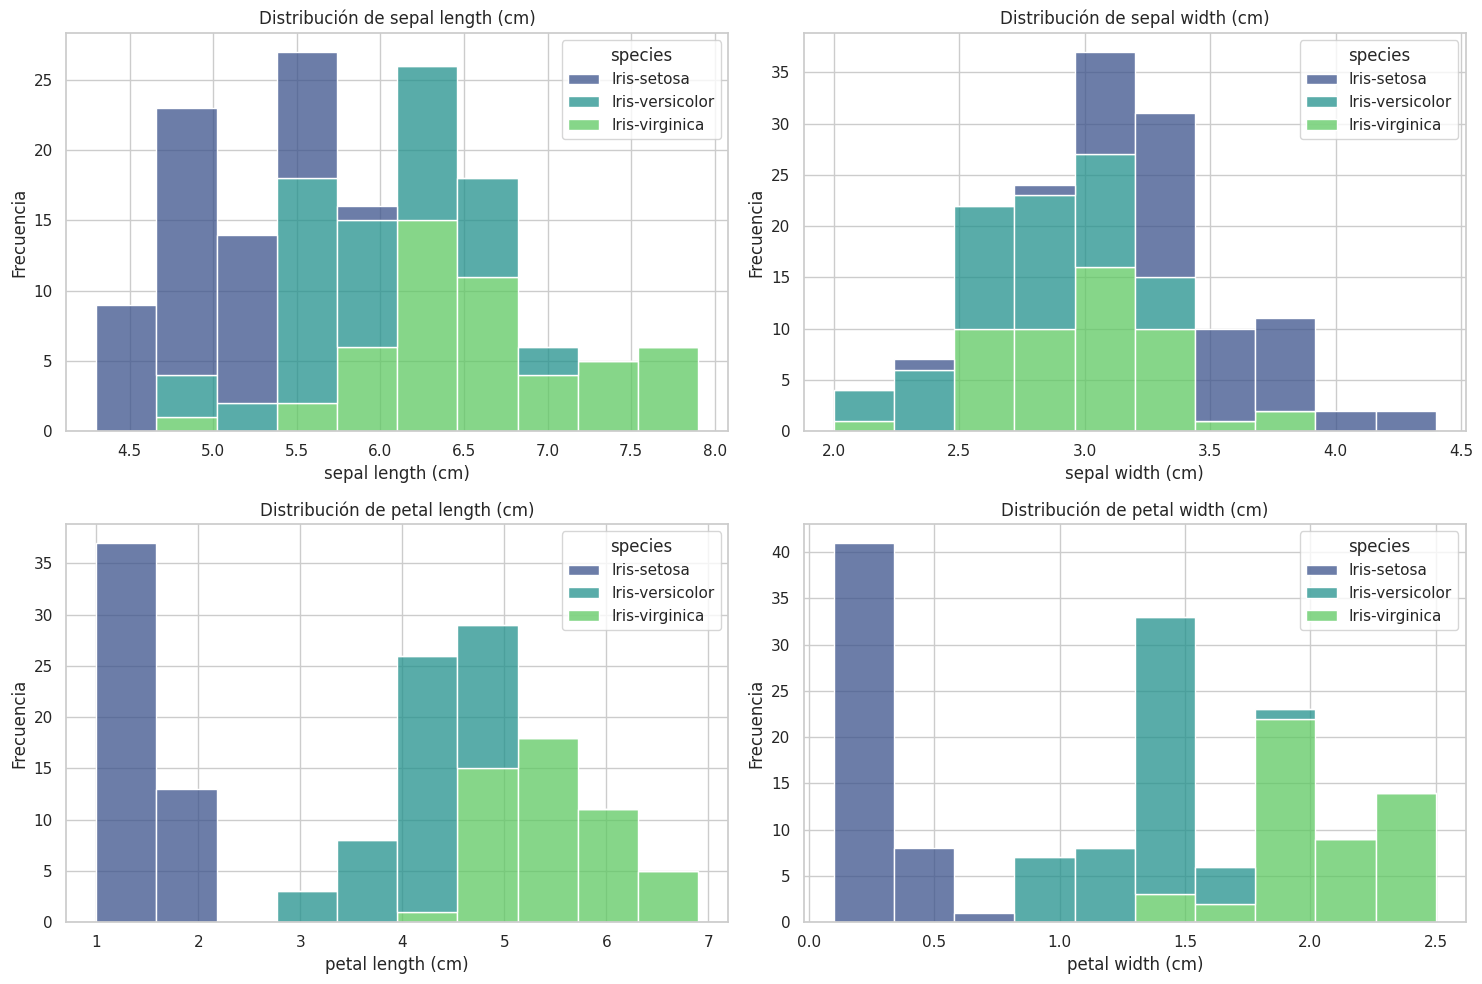

In [38]:
# Cargar y explorar los datos
df, feature_names, target_names_list = cargar_datos()

# Crear un mapeo de target numérico a nombre de especie para usarlo después
target_names_map = {i: name for i, name in enumerate(target_names_list)}


# Visualizar los datos
visualizar_datos(df)

### 3.2. Creación del Sistema Fuzzy

**Objetivo:** Llamar a la función `crear_sistema_fuzzy` para construir el sistema de inferencia con las variables, funciones de pertenencia y reglas definidas.


Creando el sistema fuzzy...

Visualizando Funciones de Pertenencia:


/home/santiago/anaconda3/envs/MADSI/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


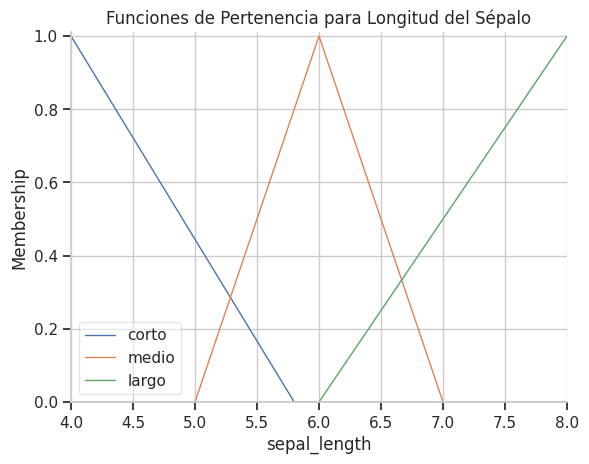

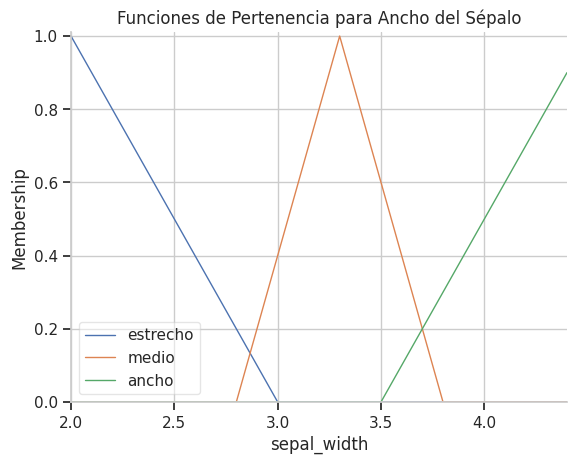

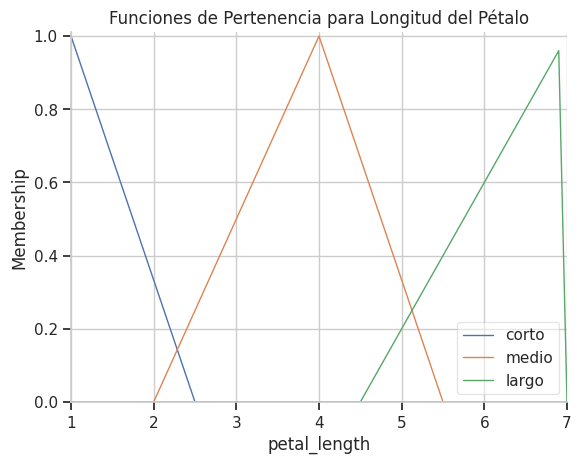

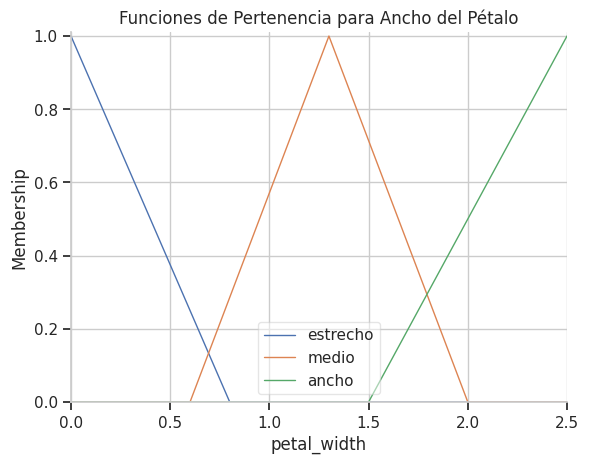

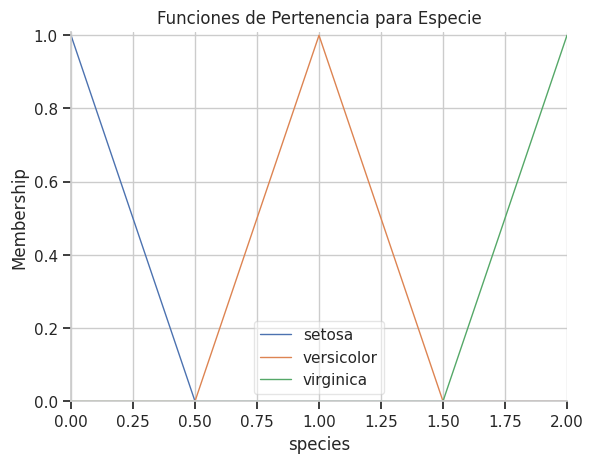


Definiendo las reglas fuzzy...

Reglas definidas!


In [39]:
# Crear el sistema fuzzy
# Pasamos feature_names aunque la función actual no lo use explícitamente para entradas,
# es una buena práctica si se quisiera generalizar más adelante.
fuzzy_system_simulator = crear_sistema_fuzzy(feature_names)

### 3.3. Evaluación del Sistema Fuzzy

**Objetivo:** Evaluar el rendimiento del sistema difuso creado utilizando el conjunto de prueba del dataset Iris.


Evaluando el sistema fuzzy...
Tamaño del conjunto de entrenamiento: 105 muestras
Tamaño del conjunto de prueba: 45 muestras

Muestra de Prueba 1:
  Características: SL=7.3, SW=2.9, PL=6.3, PW=1.8
  Clase Real: virginica (2)
  Predicción: virginica (2)
  Valor Fuzzy de Salida: 1.7853

Muestra de Prueba 2:
  Características: SL=6.1, SW=2.9, PL=4.7, PW=1.4
  Clase Real: versicolor (1)
  Predicción: versicolor (1)
  Valor Fuzzy de Salida: 1.1336

Muestra de Prueba 3:
  Características: SL=6.3, SW=2.8, PL=5.1, PW=1.5
  Clase Real: virginica (2)
  Predicción: versicolor (1)
  Valor Fuzzy de Salida: 1.2879

Muestra de Prueba 4:
  Características: SL=6.3, SW=3.3, PL=4.7, PW=1.6
  Clase Real: versicolor (1)
  Predicción: versicolor (1)
  Valor Fuzzy de Salida: 1.0826

Muestra de Prueba 5:
  Características: SL=6.1, SW=3.0, PL=4.9, PW=1.8
  Clase Real: virginica (2)
  Predicción: versicolor (1)
  Valor Fuzzy de Salida: 1.2689

Precisión del sistema fuzzy en el conjunto de prueba: 0.8889


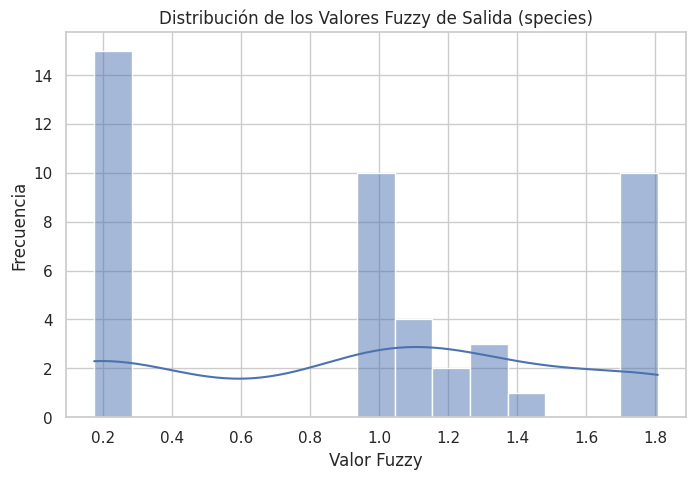

In [40]:
# Evaluar el sistema fuzzy
# Asegurarse que fuzzy_system_simulator no sea None si hubo algún problema en la creación.
if fuzzy_system_simulator:
    evaluar_sistema_fuzzy(fuzzy_system_simulator, df, feature_names, target_names_list)
else:
    print("El simulador del sistema fuzzy no fue creado. No se puede evaluar.")

### 3.4. Análisis de un Ejemplo Específico

**Objetivo:** Probar el sistema con un ejemplo individual para observar el proceso de inferencia y la salida desfusificada.

In [41]:
# Analizar un ejemplo específico
# Ejemplo de una flor versicolor típica (valores aproximados)
ejemplo_iris = {
    'sepal_length': 5.9, #rango [4.3, 7.9]
    'sepal_width': 3.0,  #rango [2.0, 4.4]
    'petal_length': 4.2, #rango [1.0, 6.9]
    'petal_width': 1.5   #rango [0.1, 2.5]
}
# Ejemplo de una setosa
# ejemplo_iris = {
# 'sepal_length': 5.1, 'sepal_width': 3.5, 'petal_length': 1.4, 'petal_width': 0.2
# }
# Ejemplo de una virginica
# ejemplo_iris = {
# 'sepal_length': 6.7, 'sepal_width': 3.0, 'petal_length': 5.2, 'petal_width': 2.3
# }


if fuzzy_system_simulator:
    analizar_ejemplo(fuzzy_system_simulator, ejemplo_iris, target_names_map)
else:
    print("El simulador del sistema fuzzy no fue creado. No se puede analizar un ejemplo.")


Analizando un ejemplo específico...

Características de la muestra:
  - Longitud del sépalo: 5.9 cm
  - Ancho del sépalo: 3.0 cm
  - Longitud del pétalo: 4.2 cm
  - Ancho del pétalo: 1.5 cm

Especie predicha: versicolor (Clase 1)
Valor Fuzzy de Salida: 1.0000
Error al procesar el ejemplo específico: {'sepal_length': 5.9, 'sepal_width': 3.0, 'petal_length': 4.2, 'petal_width': 1.5}. Error: 'generator' object is not subscriptable


## 4. Conclusiones del Ejercicio

**Resumen de Hallazgos:**
* Se cargó y exploró el dataset Iris, identificando las distribuciones de las características para cada especie.
* Se diseñó un sistema de control de lógica difusa con cuatro antecedentes (características de la flor) y un consecuente (especie).
* Se definieron funciones de pertenencia triangulares para cada variable lingüística.
* Se establecieron 6 reglas difusas que intentan capturar el conocimiento experto sobre cómo las características se relacionan con las especies de Iris.
* La evaluación en el conjunto de prueba arrojó una precisión de [**Completar con la precisión obtenida**]. Este valor indica qué tan bien el sistema generaliza a datos no vistos.
* El análisis de un ejemplo específico mostró el valor de salida difuso y la clasificación resultante, junto con la visualización del proceso de inferencia.

**Desafíos y Mejoras Potenciales:**
* **Definición de Reglas:** La creación de reglas efectivas es crucial y a menudo iterativa. Un conjunto de reglas más exhaustivo o refinado podría mejorar la precisión.
* **Funciones de Pertenencia:** La forma y los rangos de las funciones de pertenencia también impactan significativamente el rendimiento. Se podrían probar otras formas (gaussianas, trapezoidales) o ajustar los rangos.
* **Superposición de Clases:** Iris-versicolor e Iris-virginica tienen características que se superponen considerablemente, lo que hace que la clasificación sea intrínsecamente más difícil para estas dos especies en comparación con Iris-setosa, que es más distintiva.
* **Desfusificación:** El método de desfusificación (centroide por defecto) y la interpretación de la salida numérica para mapearla a una clase discreta también son puntos a considerar. Los umbrales elegidos para pasar del valor fuzzy a la clase pueden necesitar ajuste.
* **Cobertura de Reglas:** Si algunas muestras no activan ninguna regla, el sistema no puede producir una salida. Esto sugiere que el conjunto de reglas o las funciones de pertenencia podrían no cubrir todo el espacio de características de entrada.

**Aprendizaje General:**
Este ejercicio ilustra el proceso de diseño de un sistema de lógica difusa para un problema de clasificación. Demuestra cómo se pueden traducir observaciones cualitativas y conocimiento del dominio en un modelo funcional. Aunque la precisión puede no igualar a la de algoritmos de aprendizaje automático más sofisticados para este dataset en particular, los sistemas difusos ofrecen la ventaja de la interpretabilidad y la capacidad de incorporar conocimiento experto de forma explícita.

*(Nota: Los resultados específicos como la precisión deben completarse después de ejecutar el notebook).**